In [1]:
import xgboost as xgb
import pandas as pd

# Load training data
train_file = "/home/jesse/Projects/CWP_RL/03_XGBoost_Return_Prediction/training/train_2010_2020.csv"
train_df = pd.read_csv(train_file)

# Load validation data
valid_file = "/home/jesse/Projects/CWP_RL/03_XGBoost_Return_Prediction/training/valid_2021_2021.csv"
valid_df = pd.read_csv(valid_file)

print("Dataframe loaded!")

Dataframe loaded!


In [2]:
# Take a look at the training set
print("Description of Training Data: \n", train_df.describe().to_markdown())
print("\nTraining Data Types\n", train_df.dtypes)


Description of Training Data: 
 |       |           Open |           High |            Low |          Close |      Volume |    Return_1d |    Return_5d |   Return_10d |   Return_50d |   Volatility_5d |   Volatility_10d |   Volatility_20d |         SMA_10 |         SMA_50 |        SMA_200 |       RSI_14 |   Volume_Change_5d |   Volume_Change_10d |
|:------|---------------:|---------------:|---------------:|---------------:|------------:|-------------:|-------------:|-------------:|-------------:|----------------:|-----------------:|-----------------:|---------------:|---------------:|---------------:|-------------:|-------------------:|--------------------:|
| count |    1.19315e+06 |    1.19315e+06 |    1.19315e+06 |    1.19315e+06 | 1.19315e+06 |  1.19315e+06 |  1.19315e+06 |  1.19315e+06 |  1.19315e+06 |     1.19315e+06 |      1.19315e+06 |      1.19315e+06 |    1.19315e+06 |    1.19315e+06 |    1.19315e+06 |  1.19315e+06 |        1.19315e+06 |         1.19315e+06 |
| mean  |   75.55

In [3]:
# Take a look at the validation set
print("Description of Validation Data: \n", valid_df.describe().to_markdown())
print("\nValidation Data Types\n", valid_df.dtypes)

Description of Validation Data: 
 |       |        Open |        High |         Low |       Close |           Volume |       Return_1d |       Return_5d |      Return_10d |     Return_50d |   Volatility_5d |   Volatility_10d |   Volatility_20d |      SMA_10 |       SMA_50 |      SMA_200 |       RSI_14 |   Volume_Change_5d |   Volume_Change_10d |
|:------|------------:|------------:|------------:|------------:|-----------------:|----------------:|----------------:|----------------:|---------------:|----------------:|-----------------:|-----------------:|------------:|-------------:|-------------:|-------------:|-------------------:|--------------------:|
| count | 124009      | 124009      | 124009      | 124009      | 124009           | 124009          | 124009          | 124009          | 124009         | 124009          |  124009          |  124009          | 124009      | 124009       | 124009       | 124009       |     124009         |      124009         |
| mean  |    168.945  | 

In [4]:
# Split features and target
X_train = train_df.drop(columns=["Date", "Stock_ID", "Return_1d"])
y_train = train_df["Return_1d"]

X_valid = valid_df.drop(columns=["Date", "Stock_ID", "Return_1d"])
y_valid = valid_df["Return_1d"]

# Convert to DMatrix format
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
valid_dmatrix = xgb.DMatrix(X_valid, label=y_valid)

# Set up hyperparameters
params = {
    'learning_rate': 0.01,  
    'max_depth': 12,  
    'min_child_weight': 1,  
    'gamma': 0,  
    'subsample': 0.8,  
    'colsample_bytree': 0.8,  
    'lambda': 0,  
    'alpha': 0,  
    'objective': 'reg:squarederror',  
    'booster': 'gbtree',  
    'eval_metric': 'rmse',  
    'tree_method': 'hist',  
    'device': 'cuda',  
}

# Train the model with validation
model = xgb.train(
    params=params, 
    dtrain=train_dmatrix, 
    num_boost_round=50000,  # Max trees
    evals=[(train_dmatrix, 'train'), (valid_dmatrix, 'valid')],  # Track validation
    early_stopping_rounds=1000,  # Stops if no improvement in 50 rounds
    verbose_eval=10  # Print every 10 rounds
)

# Save the trained model
model_path = '/home/jesse/Projects/CWP_RL/03_XGBoost_Return_Prediction/xgboost_model.bin'
model.save_model(model_path)

print(f"Model trained successfully and saved at {model_path}")


[0]	train-rmse:0.01957	valid-rmse:0.01827
[10]	train-rmse:0.01906	valid-rmse:0.01790
[20]	train-rmse:0.01861	valid-rmse:0.01761
[30]	train-rmse:0.01819	valid-rmse:0.01732
[40]	train-rmse:0.01784	valid-rmse:0.01710
[50]	train-rmse:0.01752	valid-rmse:0.01689
[60]	train-rmse:0.01724	valid-rmse:0.01672
[70]	train-rmse:0.01700	valid-rmse:0.01658
[80]	train-rmse:0.01679	valid-rmse:0.01646
[90]	train-rmse:0.01660	valid-rmse:0.01636
[100]	train-rmse:0.01643	valid-rmse:0.01626
[110]	train-rmse:0.01628	valid-rmse:0.01619
[120]	train-rmse:0.01614	valid-rmse:0.01613
[130]	train-rmse:0.01601	valid-rmse:0.01608
[140]	train-rmse:0.01589	valid-rmse:0.01603
[150]	train-rmse:0.01579	valid-rmse:0.01599
[160]	train-rmse:0.01570	valid-rmse:0.01596
[170]	train-rmse:0.01560	valid-rmse:0.01593
[180]	train-rmse:0.01553	valid-rmse:0.01591
[190]	train-rmse:0.01546	valid-rmse:0.01588
[200]	train-rmse:0.01539	valid-rmse:0.01586
[210]	train-rmse:0.01533	valid-rmse:0.01585
[220]	train-rmse:0.01527	valid-rmse:0.01583

/tmp/ipykernel_102338/4024646340.py:41: UserWarning: [15:19:55] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  model.save_model(model_path)


Model trained successfully and saved at /home/jesse/Projects/CWP_RL/03_XGBoost_Return_Prediction/xgboost_model.bin


Validation MAE: 0.008805454166225708
Validation R²: 0.5015356471214173


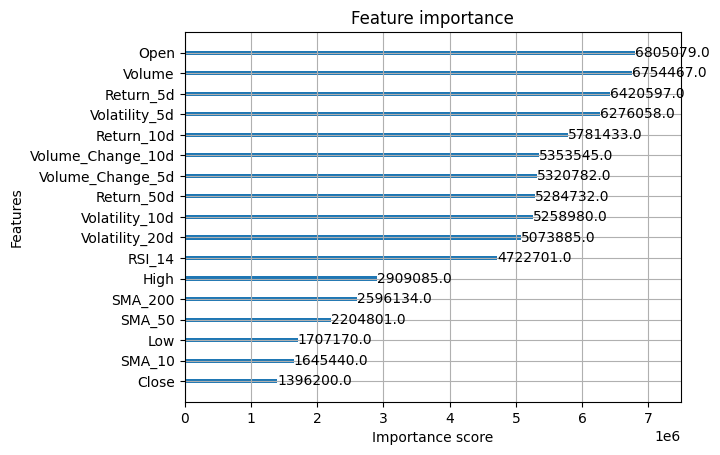

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

preds = model.predict(xgb.DMatrix(X_valid))
mae = mean_absolute_error(y_valid, preds)
print("Validation MAE:", mae)

r2 = r2_score(y_valid, preds)
print("Validation R²:", r2)

xgb.plot_importance(model)
plt.show()


In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix

# Load test data
test_path = "/home/jesse/Projects/CWP_RL/03_XGBoost_Return_Prediction/training/test_2022_2025.csv"
test_df = pd.read_csv(test_path)

# Prepare X (features) and y (target: 1-day return)
X_test = test_df.drop(columns=["Date", "Stock_ID", "Return_1d"])  # Drop non-feature columns
y_test = test_df["Return_1d"]

# Convert test features to DMatrix
test_dmatrix = xgb.DMatrix(X_test)

# Load trained model
model_path = "/home/jesse/Projects/CWP_RL/03_XGBoost_Return_Prediction/xgboost_model.bin"
model = xgb.Booster()
model.load_model(model_path)

# Make predictions
y_pred = model.predict(test_dmatrix)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)  # MSE
rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

# Convert predictions to binary (0 = negative, 1 = positive) for classification metrics
y_test_binary = (y_test > 0).astype(int)
y_pred_binary = (y_pred > 0).astype(int)

# Compute accuracy, F1 score, and confusion matrix
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Organize results in a table (Pandas DataFrame)
metrics = {
    'Metric': ['RMSE', 'MAE', 'R² Score', 'Accuracy', 'F1 Score'],
    'Value': [rmse, mae, r2, accuracy, f1]
}

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Confusion Matrix as DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], 
                               index=['Actual Negative', 'Actual Positive'])

# Print the results
print("### Evaluation Metrics ###")
print(metrics_df)
print("\n### Confusion Matrix ###")
print(conf_matrix_df)


### Evaluation Metrics ###
     Metric     Value
0      RMSE  0.014485
1       MAE  0.009687
2  R² Score  0.490489
3  Accuracy  0.737489
4  F1 Score  0.751195

### Confusion Matrix ###
                 Predicted Negative  Predicted Positive
Actual Negative              137825               58740
Actual Positive               47299              160077
